# Analysis of Norwegian and German electricity markets

Candidate numbers: 21, 33 and 52

## Load data

### Importing packages

In [1]:
# Importing packages that will be used to solve the different tasks.

import glob                            
import pandas as pd
import matplotlib.pyplot as plt

### Importing dataset 1: DayAheadPrices

In [2]:
data = []                                                                               # Creates a empty list.

DATA_PATH = './data/DayAheadPrices_12.1.D'                                              # The data path to dataset 1: DayAheadPrices..

files = glob.glob(f'{DATA_PATH}/*')                                                     # Using glob.glob to add all datafiles from the folder.

for file in files:                                                                      # Using a for loop, to loop through the datafiles found with glob.glob.
    fn = pd.read_csv(file, sep ='\t', parse_dates=['DateTime'], index_col='DateTime',   # Reads the csv file, parsing datetime string into datetime objects, and adding 'DateTime' as the index.
        usecols=['DateTime','ResolutionCode','MapCode','Price'])                        # Restricting the data to only relevant columns.
    
    data.append(fn)                                                                     # Appending the dataframe to the list data.

df = pd.concat(data).sort_index(ascending=True)                                         # Mergin all the data creating one dataFrame, also sorts the DateTime index in ascending order.
df = df.query('MapCode == "NO2" or MapCode == "DE_LU" and ResolutionCode == "PT60M"')   # Further restricting the data to only NO2 and germany, and hourly observations.
df

,ResolutionCode,MapCode,Price
DateTime,,,
2019-01-01 00:00:00,PT60M,NO2,49.25
2019-01-01 00:00:00,PT60M,DE_LU,10.07
2019-01-01 01:00:00,PT60M,DE_LU,-4.08
2019-01-01 01:00:00,PT60M,NO2,49.17
2019-01-01 02:00:00,PT60M,DE_LU,-9.91
...,...,...,...
2023-12-31 21:00:00,PT60M,NO2,61.77
2023-12-31 22:00:00,PT60M,DE_LU,2.44
2023-12-31 22:00:00,PT60M,NO2,59.31


### Importing dataset 2: PhysicalFlows

In [3]:
data = []                                                                                  # Creates a empty list.                              

DATA_PATH = './data/PhysicalFlows_12.1.G'                                                  # The data path to dataset 2: PhysicalFlows...

files = glob.glob(f'{DATA_PATH}/*')                                                        # Using glob.glob to add all the datafiles from the folder.

for file in files:                                                                         # Looping through all the files adding them to the list 'data'.
    fn = pd.read_csv(file, sep ='\t', parse_dates=['DateTime'], index_col='DateTime'       # Also restricting the data to only show flows between NO2 and Germany.
        ).query('(InMapCode == "NO2" & OutMapCode == "DE_LU") | (InMapCode == "DE_LU" & OutMapCode == "NO2")')
    
    data.append(fn)                                                                        # Appending files to a list

df2 = pd.concat(data).sort_index(ascending=True)                                           # Merging all the files into one dataframe.
df2

,InMapCode,OutMapCode,FlowValue
DateTime,,,
2020-09-01 22:00:00,DE_LU,NO2,0.0000
2020-09-01 22:00:00,NO2,DE_LU,0.0000
2020-09-01 23:00:00,DE_LU,NO2,0.0000
2020-09-01 23:00:00,NO2,DE_LU,0.0000
2020-09-02 00:00:00,DE_LU,NO2,0.0000
...,...,...,...
2023-12-31 21:00:00,NO2,DE_LU,1348.5225
2023-12-31 22:00:00,NO2,DE_LU,1350.5975
2023-12-31 22:00:00,DE_LU,NO2,0.0000


We have now loaded in the datasets as two dataframes:

**Dataset 1**: `DayAheadPrices_12.1.D`, which we have stored as the variable `df`.  
**Dataset 2**: `PhysicalFlows_12.1.G`, which we have stored as the variable `df2`.

## Tasks

### Task 1



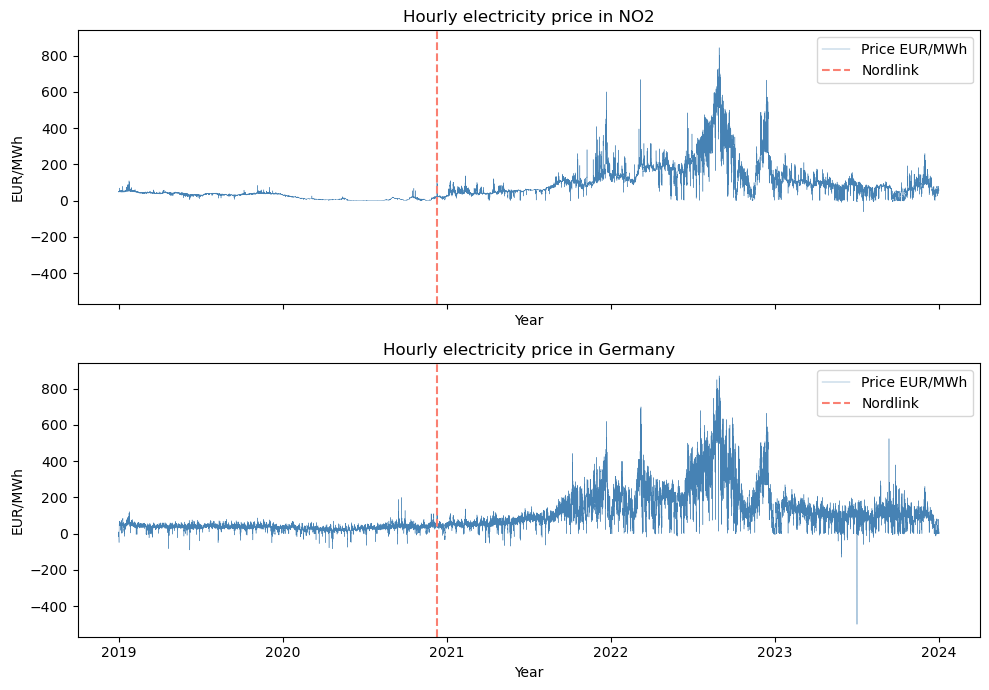

In [4]:
fig1, axes = plt.subplots(2,1, sharex=True, sharey=True, figsize=(10,7))                    # Creates subplots with shared x- and y-axis.

Country = ['NO2', 'Germany']                                                                # List of the countries/price zones, NO2 and Germany.

xvalues = df.index.drop_duplicates()                                                        # Gets the x-values for the plots, removes duplicates.
yvalues0 = df[df['MapCode'] == 'NO2']['Price']                                              # Gets the y-values for NO2.
yvalues1 = df[df['MapCode'] == 'DE_LU']['Price']                                            # Gets the y-values for Germany.

yvalues = [yvalues0, yvalues1]                                                              # Puts the yvalues in a list together.

for i in range(2):                                                                          # For loop for plotting the two subplots.
    axes[i].plot(xvalues, yvalues[i], lw=0.3, label='Price EUR/MWh', c='steelblue')         # Plots the electricity graphs.
    axes[i].axvline(pd.to_datetime('2020-12-09'), ls='--', c='salmon', label='Nordlink')    # Plots the vertical line for opening of Nordlink.
    axes[i].set_title(f'Hourly electricity price in {Country[i]}')                          # Adding titles and labels. 
    axes[i].set_xlabel('Year')
    axes[i].set_ylabel('EUR/MWh')                                   
    axes[i].legend()            

fig1.tight_layout()                                                                         # Adjusting the layout.                                                    

#### Conclusion 1
The subplots above demonstrate how the electricity prices in NO2 and Germany have developed over time. Although electricity prices appear to fluctuate more in Germany on a short-term basis, both countries follow the same trend over time. Prior to the opening of Nordlink, both NO2 and Germany had fairly low and stable electricity prices. Immediately after the Nordlink activation, both markets grew slightly. However, approximately one year after the Nordlink activation, a notable increase in price occurred. The price increased significantly until the end of 2022, after which it stabilized at a lower level. Nonetheless, the prices stay more volatile following the launch of Nordlink.

At some points in time, the electricity prices are negative, this is particularly evident in Germany. This indicates that the energy production's costs exceed the revenues. This could be the result of a surplus in energy production relative to demand.


### Task 2


In [5]:
df = df.loc['2019':'2023'].copy()               # Restricting the data for the period 2019-2023, makes a copy() to avoid dataframe warnings.
df['Year'] = df.index.year                      # Creating a new colum 'Year' containing only the relevant years, 2019-2023

groups = df.groupby(['MapCode','Year'])         # Create a group, with the new colum 'Year' and 'MapCode' (NO2 or Germany).

table = groups.agg(                             # Creates a new table that calculates the required statistics.
    Mean = ('Price', 'mean'),                   
    Median = ('Price', 'median'),
    Standard_deviation = ('Price', 'std'),
    Min = ('Price', 'min'),
    Max = ('Price', 'max'),
).round(2)                                      # Rounding to two decimals
table                                           # Prints the table

Mean  Median  Standard_deviation     Min     Max
MapCode Year                                                    
DE_LU   2019   37.67   38.06               15.52  -90.01  121.46
        2020   30.47   30.99               17.50  -83.94  200.04
        2021   96.85   75.48               73.68  -69.00  620.00
        2022  235.44  208.34              142.82  -19.04  871.00
        2023   95.18   98.02               47.58 -500.00  524.27
NO2     2019   39.26   38.81                8.23    5.86  109.45
        2020    9.29    6.95                8.26   -1.73   99.92
        2021   75.11   59.34               47.22   -1.97  600.16
        2022  211.28  181.13              125.85    0.04  844.00
        2023   79.44   80.46               36.28  -61.84  261.85

#### Conclusion 2
In recent years, electricity prices in NO2 and Germany have become more extreme. The table above clearly illustrates this increase in price. Although the prices vary in both areas, they follow a similar trend. In 2019 and 2020, before the opening of Nordlink, the prices in Germany were relatively stable at around 30-40 EUR/MWh. In NO2 during the same period, the price ranged from 10 to 40 EUR/MWh. Shortly following the launch of Nordlink, in 2021, both areas experienced a rapid increase in price, with average prices nearly 300% higher than the year before in Germany, and 800% to the prior year in NO2. The substantial growth led to extreme prices in 2022 of 871 EUR/MWh and 844 EUR/MWh, which were the maximum electricity prices at this time in Germany and NO2 respectively. The trend of exponential growth continued until 2023, before the prices in both areas stabilize. Prices remain significantly higher than before Nordlink's activation.

### Task 3

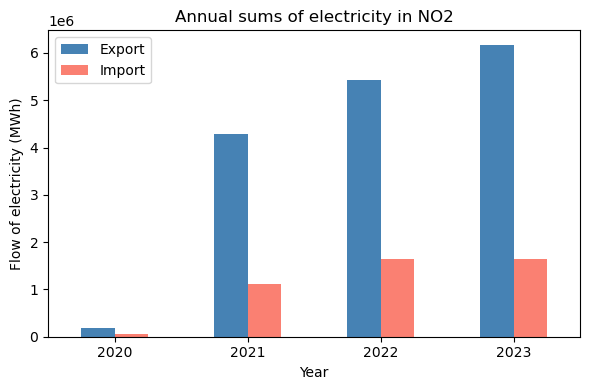

In [6]:
df2['Year'] = df2.index.year                                                                        # Creates a new colum 'year' based on the 'DateTime' index.
df2['Indicator'] = df2.apply(lambda x: 'Import' if x['InMapCode'] == 'NO2' else 'Export', axis = 1) # New colum 'Indicator' to tell if its import or export. Using axis = 1 to apply to relevant colum 'InMapcode'

annual_sum = df2.groupby(['Year','Indicator'])['FlowValue'].sum().unstack(level='Indicator')        # New dataframe with colums: Year, Export, Import. Unstack is used to get seperate colums for 'export' and 'import'

fig3, ax = plt.subplots(figsize=(6,4))                                                              # Creates the plot, and adjusting the figsize. 

annual_sum.plot(kind='bar', color=['steelblue', 'salmon'], ax=ax)                                   # Plots the new 'annual_sum' dataframe.
ax.set_title('Annual sums of electricity in NO2')                                                   # Adding title.
ax.tick_params(axis='x', rotation=0)                                                                # Rotates the x-ticks 0 degrees
ax.set_ylabel('Flow of electricity (MWh)')                                                                
ax.set_xlabel('Year')
ax.legend()

fig3.tight_layout()                                                                                 # Adjusting the layout.

#### Conclusion 3
The bar plot above demonstrates the annual sum of imports and exports of electricity from NO2 to Germany. As illustrated in blue, exports from NO2 to Germany have notably exceeded imports. In the following years, the electricity export has grown steadily, while imports have remained lower and have shown relatively modest growth. It is also worth noting that the lower values seen in 2020 are due to Nordlink opening <u>desember</u> 2020.

### Task 4

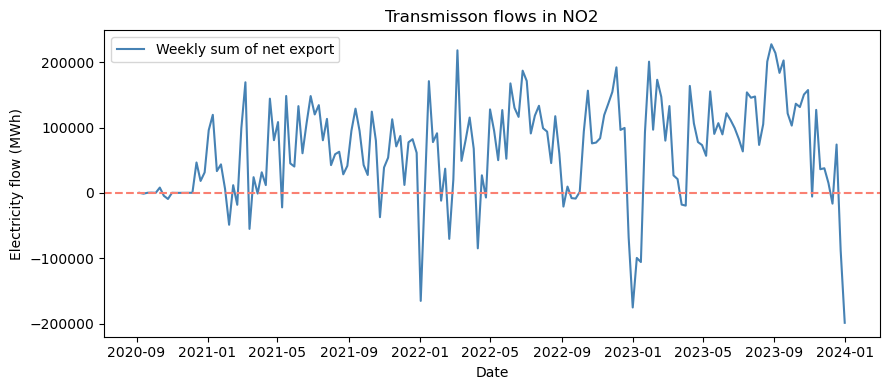

In [7]:
# New colum 'NetExport', where the FlowValue is either positve or negative, depening on if its export or import. 
df2['NetExport'] = df2.apply(lambda x: x['FlowValue'] if x['InMapCode'] == 'DE_LU' else -x['FlowValue'], axis=1)    

df2_weekly = df2.resample('W')['NetExport'].sum()                       # Resampeling the data to a weekly frequency, while summing the values in the 'NetExport' colum.

fig4, ax = plt.subplots(figsize=(9,4))                                  # Creates the plot.

ax.plot(df2_weekly, label='Weekly sum of net export', c='steelblue')    # Plots the the new weekly dataframe, adding label and color.
ax.axhline(y=0, c='salmon', ls='--', label='')                          # Creates a horizontal line at y=0.
ax.set_title('Transmisson flows in NO2')                                # Adding titles and labels in the figure.
ax.set_ylabel('Electricity flow (MWh)')
ax.set_xlabel('Date')
ax.legend()

fig4.tight_layout()                                                      # Adjusting the layout.

#### Conclusion 4
The line plot above shows the weekly sum of net exports from NO2 to Germany over time. Positive values indicates that NO2 is exporting more energy than its importing, while negative values indicate the opposite. Based on the graph, NO2 has not consistently exported more than it has imported. The data shows several weeks of negative net export, which typically occurs during winter month, where the graph makes consistent spikes below the red line. This can in particular be seen around January the last three years. 

### Task 5

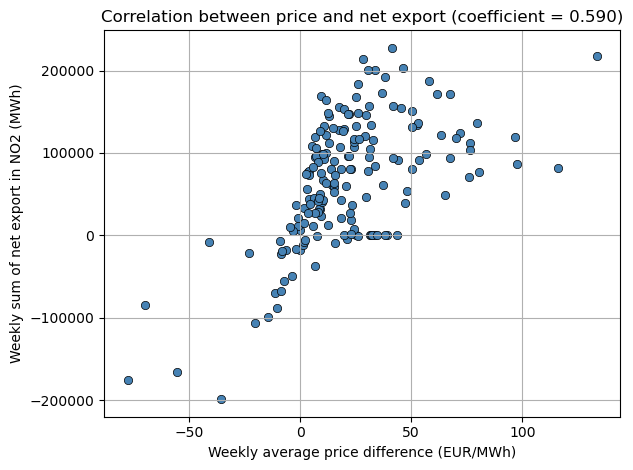

In [8]:
# In this task we continue using the dataframe made in task 4 (df2_weekly).
# We also decide to restrict dataset 1, to the same date as the first obervations in dataset 2, which is the start of testing Nordlink in september. 

df_hourly = df.loc['2020-09-01':].copy()                                                                # Restricting the original dataframe to match the lenght of observations in dataset 2 (df2).                                            
df_hourly['PriceDiff'] = df[df['MapCode'] == 'DE_LU']['Price'] - df[df['MapCode'] == 'NO2']['Price']    # New colum 'PriceDiff' finding the hourly price difference.
df_weekly = df_hourly['PriceDiff'].resample('W').mean()                                                 # Finding the weekly average of the price difference.

correlation = df_weekly.corr(df2_weekly)                                                                # Computing the correlation, between the two dataframes.

fig5, ax = plt.subplots()                                                                               # Creates the plot.

ax.scatter(df_weekly, df2_weekly, c='steelblue', edgecolors='black', linewidth=0.5)                     # Creating a scatter plot between the average price difference and the sum of net export.
ax.set_xlabel('Weekly average price difference (EUR/MWh)')                                              # Adding labels to y- and x-axis.
ax.set_ylabel('Weekly sum of net export in NO2 (MWh)')
ax.set_title(f'Correlation between price and net export (coefficient = {correlation:.3f})', size ='12') # Tiltle with the computed correlation.
ax.grid()

fig5.tight_layout()                                                                                     # Adjusting the layout.

#### Conclusion 5
The scatter plot above describes the relationship between the weekly sum of net exports in NO2 and the weekly average price difference between Germany and NO2. It illustrates a positive relationship between the weekly sum of net exports and the weekly average price difference. The correlation coefficient is 0.590. NO2 tends to export more electricity to Germany when German prices are higher and import more when German prices are lower.

### Task 6

During the assignment, we utilized a variety of resources and tools to optimize the functionality and efficiency of our code. 
First and foremost, we used the Python libraries pandas and matplotlib. We retrieved “plt.tight_layout” from matplotlib and used it in every task to fit subplots within the figure area. Similarly, we used “plt.savefig” to save output figures to the folder we are working in. The pandas library was used in task 1, 3 and 4. In task 1, we used “pd.to_datetime” to convert the ‘DateTime’ column into a pandas datetime object. For task 3 and 4, we used the “DataFrame.apply” function to apply a lambda function to the entire “df2” dataframe. In addition, we used the function “DataFrame.unstack” in task 3 in order to have separate columns for export and import for each area. 

For this assignment, we used generative AI in ChatGPT as a tool for analyzing technical and grammatical errors, and debugging of code. In addition, when struggling to finish writing singular lines of code, ChatGPT acted as an assisting resource, in order to write correct syntax. 


### References
Matplotlib. (2024). matplotlib.pyplot.savefig. From Matplotlib:  
https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.savefig.html

Matplotlib. (2024). matplotlib.pyplot.tight_layout. From Matplotlib:  
https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.tight_layout.html

OpenAI. (2024). ChatGPT. From https://chatgpt.com/?ref=dotcom

Pandas. (2024). pandas.DataFrame.apply. From Pandas:  
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html

Pandas. (2024). pandas.DataFrame.unstack. From Pandas:  
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.unstack.html

Pandas. (2024). pandas.to_datetime. From Pandas:  
https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html




### Downloading figures
Remove ''', and run the code to save the figures and data table in folder 'figures'.

In [9]:
'''
fig1.savefig('figures/figure_task1.png')
table.to_excel('figures/table_task2.xlsx')
fig3.savefig('figures/figure_task3.png') 
fig4.savefig('figures/figure_task4.png')
fig5.savefig('figures/figure_task5.png')
'''